# Neural Style Transfer
Consiste en una tecnica de optimizacion en la que se usan dos imaganes, una imagen contenedor y una imagen de estilo(como el estilo de pintura de un famoso pintor) y se encarga de unirlas, el resultado es la imagen, pero parece pintada por el artista.

Vamos a montar el entorno necesario para el ejercicio.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf


In [0]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

La salida de nuestra red va a ser un tensor, por lo tanto vamos a necesitar una funcion que nos transforme ese tensor en una imagen, por ende necesitamos definir una funcion que lo haga, además nos podemos encontrar que algunas dimensiones tiene tamaño 1 por tanto no nos servirian así que eliminamos esa dimension que nos estorba

In [0]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.size(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [0]:
# content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_path = "./content.jpg"
# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
# style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
style_path = "./nocheEstrellada.jpg"

Ahora vamos a necesitar dos funiones extras una que nos cargue las imagenes y las limite a 512 para que tengan un tamaño estandar y otra funcion que nos ayude a mostrar la imagen

In [0]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)

    img = img[tf.newaxis, :]
    return img

In [0]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)
        

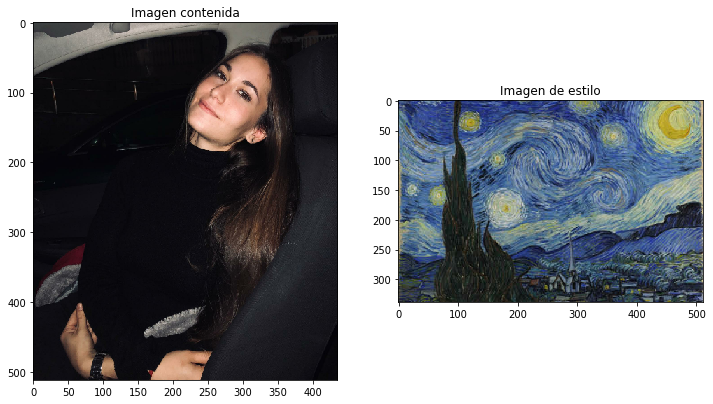

In [0]:
content_image = load_img(content_path);
style_image = load_img(style_path);

plt.subplot(1,2,1)
imshow(content_image, "Imagen contenida")

plt.subplot(1,2,2)
imshow(style_image, "Imagen de estilo")

# Neural style transfer (TF-Hub)
Obviamente este algoritmo ya está demostrado y realizado, vamos a verlo con TF-Hub


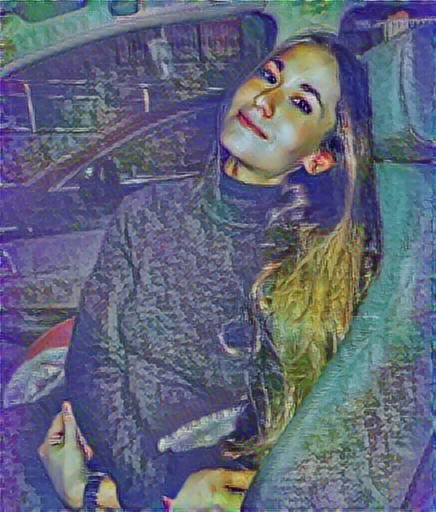

In [0]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

# Definiendo el contenido y el estilo de la representacion

Usamos las capas intermedias del modelo para extraer el contenido y el estilo que vamos a representar

Empezando por las capas de entrada, las primeras extraen caracteristicas como bordes o texturas. A medida que avanzas por la arquitectura de la red, las capas finales se encargan de identificar caracteristicas de alto nivel como por ejemplo ruedas u ojos. En este caso vamos a usar la arquitectura de red VGG19 una red preentrenada. En ragos generales lo que vamos a hacer es usar las capas superiores ya entrenadas, congelando sus pesos y actualizando los de las capas intermedias y finales.

Cargamos ahora [VGG19](https://keras.io/applications/#vgg19) y testeamos su uso en nuestra imagen para asegurarnos de que se usa correctamente.

![title](VGG19.png)



In [0]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x,(224,224))
vgg = tf.keras.applications.VGG19(include_top = True,weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [0]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name,prob) in predicted_top_5]

[('seat_belt', 0.5922401),
 ('limousine', 0.21567212),
 ('abaya', 0.05686814),
 ('minivan', 0.013846852),
 ('car_mirror', 0.011944328)]

Con estos ultimos bloques hemos visto que la VGG19 funciona y clasifica bien nuestro perro, ahora cargaremos VGG19 pero sin las capas superiores (las que vamos a usar)

In [0]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)
    
    


input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Cogemos las capas intermedias, de la red que nos permite representar el estilo y contenido de la imagen

In [0]:
#Capa donde vamos a extraer nuestro mapa de caracteristicas
content_layers = ['block5_conv2']

#Capa de estilos

style_layers = ['block1_conv1',
               'block2_conv1',
               'block3_conv1',
               'block4_conv1',
               'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Capas intermedias para el estilo y contenido
A alto nivel, para hacer que la red haga una clasificacion de imagenes,(cosa para lo que esta red está entrenada) tiene que entender la propia imagen. Esto requiere coger la imagen en crudo como una entrada de pixeles y construir una representacion interna que convierta esa imagen en una comprension compleja de las caracteristicas presentes en la imagen

Esto es una de las razones por las que las redes convolucionales son capaces de generalizar tan bien. Son capaces de extraer invariantes en las imagenes y definir caracteristicas de cada clase. Así podríamos pensar que en algun lugar dentro de la red entre la imagen en crudo y la salida, el modelo nos da un extractor de caracteristicas complejas. Accediendo a las capas intermedias del modelo podríamos ser capaces de describir la imagen contenida y la imagen de estilo

# Creando el modelo
Las redes en [tf.keras.applitations]('https://www.tensorflow.org/api_docs/python/tf/keras/applications') están diseñadas para que de manera sencilla podamos extraer el valor de las capas intermedias usando una Api de Keras

La siguiente funcion construye un modelo VGG19 que devuelve una lista de las salidas de las capas intermedias


In [0]:
def vgg_layers(layer_names):
#     Creamos un modelo vgg que retorna una lista de los valores de salida de las capas intermedias
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable= False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model([vgg.input],outputs)
    
    return model

In [0]:
# y ahora creamos nuestro modelo
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name,output in zip (style_layers, style_outputs):
    print(name)
    print(" shape ", output.numpy().shape)
    print(" min ", output.numpy().min())
    print(" max ",output.numpy().max())
    print(" mean ",output.numpy().mean())
    print()

block1_conv1
 shape  (1, 338, 511, 64)
 min  0.0
 max  646.994
 mean  21.99782

block2_conv1
 shape  (1, 169, 255, 128)
 min  0.0
 max  2366.1907
 mean  131.89268

block3_conv1
 shape  (1, 84, 127, 256)
 min  0.0
 max  5833.653
 mean  126.80572

block4_conv1
 shape  (1, 42, 63, 512)
 min  0.0
 max  14817.166
 mean  476.91312

block5_conv1
 shape  (1, 21, 31, 512)
 min  0.0
 max  3050.0515
 mean  39.52149



# Calculo del estilo
Resulta que el contenido de una imagen está representado como el valor del mapa de caracteristicas intermedio de la red

Además el estilo de una imagen puede ser descrita por las medias y la correlacion a traves de los diferentes mapas de caracteristicas. Calcular la [matriz de Gram](https://es.wikipedia.org/wiki/Matriz_de_Gram#targetText=En%20%C3%A1lgebra%20lineal%2C%20la%20matriz%20de%20Gram%20de%20un%20conjunto%20de%20vectores)que incluye esta informacion, haciendo el outer product de cada vector consigo mismo en cada localizacion y la media del outer product de todas las localizaciones

Esto se puede implementar con la funcion [tf.linaglg.einsum](https://www.tensorflow.org/api_docs/python/tf/einsum)

In [0]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

Vamos a construir el modelo que extrae el estilo y el contenido

In [0]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self,style_layers, content_layers):
        super(StyleContentModel,self).__init__()
        self.vgg = vgg_layers(style_layers+content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self,inputs):
        "Se espera que inputs sea un float normalizado (0,1)"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        
        style_outputs,content_outputs = (outputs[:self.num_style_layers],
                                        outputs[self.num_style_layers])
        
        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]
        
        content_dict = {content_name:value
                       for content_name,value
                       in zip(self.content_layers,content_outputs)}
        
        style_dict = {style_name:value
                     for style_name,value
                     in zip(self.style_layers,style_outputs)}
        
        return {'content':content_dict, 'style':style_dict}

    
    

Cuando hacemos la llamada sobre una imagen, este modelo devuelve la matriz de gram(la de estilos) de la style_layers y el contenido de la content_layers

In [0]:
extractor = StyleContentModel(style_layers,content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Estilos: ')
for name,output in sorted(results['style'].items()):
    print("  ", name)
    print("\tshape: ",output.numpy().shape)
    print("\tmin: ",output.numpy().min())
    print("\tmax: ",output.numpy().max())
    print("\tmean: ",output.numpy().mean())
    print()
    
print('Contenido: ')
for name,output in sorted(results['content'].items()):
    print("  ", name)
    print("\tshape: ",output.numpy().shape)
    print("\tmin: ",output.numpy().min())
    print("\tmax: ",output.numpy().max())
    print("\tmean: ",output.numpy().mean())
    print()


Estilos: 
   block1_conv1
	shape:  (1, 64, 64)
	min:  0.00024464368
	max:  52939.477
	mean:  461.86255

   block2_conv1
	shape:  (1, 128, 128)
	min:  0.0
	max:  56466.23
	mean:  10600.686

   block3_conv1
	shape:  (1, 256, 256)
	min:  0.0
	max:  225453.56
	mean:  7814.9106

   block4_conv1
	shape:  (1, 512, 512)
	min:  0.13794328
	max:  4146174.8
	mean:  166525.89

   block5_conv1
	shape:  (1, 512, 512)
	min:  0.0
	max:  67028.805
	mean:  1252.4689

Contenido: 
   block5_conv2
	shape:  (32, 27, 512)
	min:  0.0
	max:  1207.4749
	mean:  12.523124



# Descenso del gradiente 

Con este extractor de contenido y estilo, podemos implementar el algoritmo de la transferencia de estilos. Lo hacemos calculando el [ECM](https://es.wikipedia.org/wiki/Error_cuadr%C3%A1tico_medio) para la salida de la imagen y luego cogiendo la suma ponderada de los losses

In [0]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Ahora definimos una [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable) para guardar la imagen a optimizar

In [0]:
image = tf.Variable(content_image)

Obviamente dentro de image, vamos a tener valores de tipo float, por lo que vamos a necesitar una funcion que nos normalice los valores

In [0]:
def clip_0_1(image):
    return tf.clip_by_value(image,clip_value_min=0.0, clip_value_max=1.0)


Creamos el optimizador. El paper recomienda usar LBFGS, pero Adam funciona tambien

In [0]:
opt = tf.optimizers.Adam(learning_rate = 0.02,beta_1=0.99,epsilon=1e-1)

Necesitamos ahora una ponderacion de las dos perdidas para conseguir la perdida total (cuando me refiero a perdida es al error, por si hay confusion)

In [0]:
style_weight=1e-2
content_weight=1e4

In [0]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                          for name in style_outputs.keys()])
    
    style_loss *= style_weight/num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                          for name in content_outputs.keys()])
    
    content_loss *= content_weight/num_content_layers
    
    loss = style_loss+ content_loss
    
    return loss


Ahora usamos [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) para actualizar la imagen

In [0]:

def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        
    grad = tape.gradient(loss,image)
    opt.apply_gradients([(grad,image)])
    image.assign(clip_0_1(image))


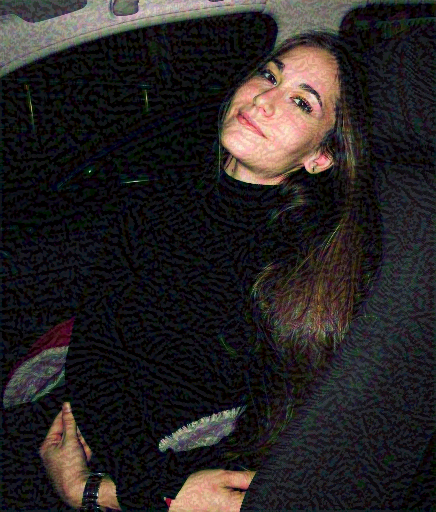

In [0]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Vemos que funciona ahora vamos a hacer que itere para un mejor resultado

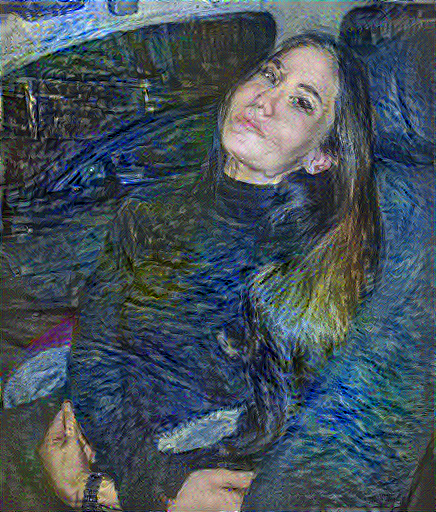

Train step: 1000
Tiempo total : 334.3


In [0]:
import time
start = time.time()

epochs = 10
step_per_epoch=100

step = 0
for n in range(epochs):
    for m in range(step_per_epoch):
        step+=1
        train_step(image)
        print(".",end="")
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
    
end = time.time()
print("Tiempo total : {:.1f}".format(end-start))

# Variacion total del error

Uno de los inconvenientes de esta implementacion es que se generan muchos elementos de alta frecuencia(tensores). Bajar la tasa en la que se generan estos elementos se puede conseguir usando 